## Introduction to visualizing data in the eeghdf files

In [1]:
# %load explore-eeghdf-files-basics.py
# Here is an example of how to do basic exploration of what is in the eeghdf file. I show how to discover the fields in the file and to plot them.
# 
# I have copied the stacklineplot from my python-edf/examples code to help with display. Maybe I will put this as a helper or put it out as a utility package to make it easier to install.

from __future__ import print_function, division, unicode_literals
%matplotlib inline
# %matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
from pprint import pprint

import stacklineplot


# matplotlib.rcParams['figure.figsize'] = (18.0, 12.0)
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

In [2]:
hdf = h5py.File('./archive/YA2741G2_1-1+.eeghdf')

In [3]:
pprint(list(hdf.items()))
pprint(list(hdf['patient'].attrs.items()))

[('patient', <HDF5 group "/patient" (0 members)>),
 ('record-0', <HDF5 group "/record-0" (10 members)>)]
[('patient_name', '2619, Subject'),
 ('patientcode', '3fe61c07d97e5b5595d647f9c1dc469e'),
 ('gender', 'Male'),
 ('birthdate', '1990-01-01'),
 ('patient_additional', ''),
 ('gestatational_age_at_birth_days', -1.0),
 ('born_premature', 'unknown')]


In [4]:
rec = hdf['record-0']
pprint(list(rec.items()))
pprint(list(rec.attrs.items()))

[('edf_annotations', <HDF5 group "/record-0/edf_annotations" (3 members)>),
 ('physical_dimensions',
  <HDF5 dataset "physical_dimensions": shape (36,), type "|O">),
 ('prefilters', <HDF5 dataset "prefilters": shape (36,), type "|O">),
 ('signal_digital_maxs',
  <HDF5 dataset "signal_digital_maxs": shape (36,), type "<i4">),
 ('signal_digital_mins',
  <HDF5 dataset "signal_digital_mins": shape (36,), type "<i4">),
 ('signal_labels', <HDF5 dataset "signal_labels": shape (36,), type "|O">),
 ('signal_physical_maxs',
  <HDF5 dataset "signal_physical_maxs": shape (36,), type "<f8">),
 ('signal_physical_mins',
  <HDF5 dataset "signal_physical_mins": shape (36,), type "<f8">),
 ('signals', <HDF5 dataset "signals": shape (36, 362200), type "<i2">),
 ('transducers', <HDF5 dataset "transducers": shape (36,), type "|O">)]
[('start_isodatetime', '2000-01-17 08:56:46'),
 ('end_isodatetime', '2000-01-17 09:26:57'),
 ('number_channels', 36),
 ('number_samples_per_channel', 362200),
 ('sample_frequen

In [5]:
signals = rec['signals']
labels = rec['signal_labels']
electrode_labels = [str(s,'ascii') for s in labels]
numbered_electrode_labels = ["%d:%s" % (ii, str(labels[ii], 'ascii')) for ii in range(len(labels))]

#### Simple visualization of EEG (brief absence seizure)

In [6]:
# plot 10s epochs (multiples in DE)
# ch0, ch1 = (0,19)
# DE = 2 # how many 10s epochs to display
#epoch = 147; ptepoch = 10*int(rec.attrs['sample_frequency'])
#stacklineplot.stackplot(signals[ch0:ch1,epoch*ptepoch:(epoch+DE)*ptepoch],seconds=DE*10.0, ylabels=electrode_labels[ch0:ch1])
#print("epoch:", epoch)


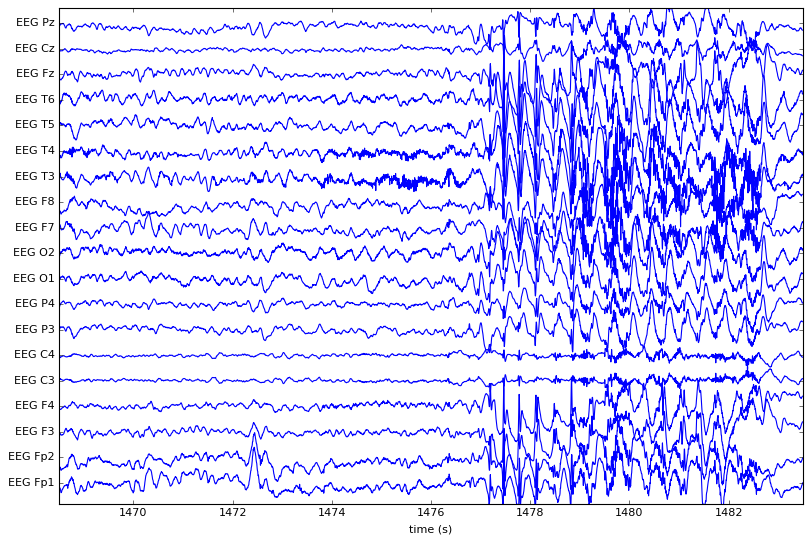

In [7]:
# search identified spasms at 1836, 1871, 1901, 1939
stacklineplot.show_epoch_centered(signals, 1476,
                        epoch_width_sec=15,
                        chstart=0, chstop=19, fs=rec.attrs['sample_frequency'],
                        ylabels=electrode_labels, yscale=3.0)

In [8]:
annot = rec['edf_annotations']
#print(list(annot.items()))
#annot['texts'][:]

In [9]:
antext = [s.decode('utf-8') for s in annot['texts'][:]]
starts100ns = [xx for xx in annot['starts_100ns'][:]]
len(starts100ns), len(antext)

(114, 114)

In [10]:
# age in years 10yo, #1 sz at 1476

In [11]:
import pandas as pd

In [12]:
df = pd.DataFrame(data=antext, columns=['text'])
df['starts100ns'] = starts100ns
df['starts_sec'] = df['starts100ns']/10**7

In [13]:
df

,text,starts100ns,starts_sec
0,REC START Biocal CAL,0,0.000
1,A1+A2 OFF,13900000,1.390
2,PAT Biocal EEG,58500000,5.850
3,PAT A_DB EEG,117500000,11.750
4,IMP CHECK ON,317800000,31.780
5,IMP CHECK OFF,348400000,34.840
6,vertex-waves,396490000,39.649
7,sleeping on back,448080000,44.808
8,head straight up,491140000,49.114
9,head on neckroll,529980000,52.998


In [14]:
df[df.text.str.contains('sz',case=False)]

,text,starts100ns,starts_sec
86,SZ START,13805120000,1380.512
88,SZ END,13842460000,1384.246
91,SZ START,14168970000,1416.897
93,SZ END,14228430000,1422.843
99,SZ START,14769330000,1476.933
103,SZ END,14832690000,1483.269


In [15]:
list(annot.items())

[('durations_char16',
  <HDF5 dataset "durations_char16": shape (114,), type "|S16">),
 ('starts_100ns', <HDF5 dataset "starts_100ns": shape (114,), type "<i8">),
 ('texts', <HDF5 dataset "texts": shape (114,), type "|O">)]